In [2]:
import numpy as np
from numpy.random import uniform,exponential,chisquare,normal,randint, shuffle
from scipy.stats import chi2,norm,invgamma, truncnorm
from scipy.special import expit
import matplotlib.pyplot as plt

## Problem 1

### (1) Describe how to generate a standard Laplace random variable by inverting the CDF.

CDF的逆如下：
$$F^{-1}(u) = \begin{cases}
ln(2u) & \text{$u \le 0.5$} \\
-ln(2(1-u)) & \text{$u > 0.5$}
\end{cases}
$$

**具体代码实现：**

In [11]:
def L(x):
    """
    Laplace函数
    """
    return 0.5 * np.exp(-np.abs(x))

def laplace(n=1):
    v_laplace = np.vectorize(_laplace)
    return v_laplace(uniform(size=n))


def _laplace(x):
    if x <= 0.5:
        return np.log(2 * x)
    else:
        return -np.log(2 * (1 - x))

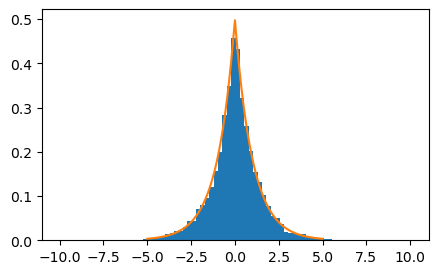

In [19]:
x = laplace(n=10000)
fig1 = plt.figure(figsize=(5, 3))
plt.hist(x, 80, density=True)
y = np.linspace(-5, 5, 1000)
z = L(y)
plt.plot(y, z)
plt.show()

### (2) Describe and implement a rejection sampling algorithm to simulate random draws from the standard normal distribution using (a multiple of) the Laplace density as the envelop function

用两个密度函数做除法：（C是待确定的常数）
$$
\frac{\sqrt{2\pi}C}{2}e^{-x+\frac{1}{2}x^2}
$$
该式应该对全部$x\in R$都恒大于1，保证Laplace盖住正态密度，其最小值在$x=1$处取得，于是令：
$$
C = \frac{2e^{1/2}}{\sqrt{2\pi}}=1.32
$$
即可保证Laplace是正态密度的envelop

In [15]:
def N(x):
    return 1 / np.sqrt(2 * np.pi) * np.exp(-0.5 * x ** 2)

def reject_sampling(f, g, g_sampler,n=1, max_iter=1000):
    sample = []
    num = 0
    iter = 0
    while num < n and iter < max_iter:
        x = g_sampler()  # 对g进行抽样
        U = uniform(size=1)
        accept = f(x) / g(x)
        if U <= accept:
            sample.append(x)
            num += 1
        iter += 1
    return np.array(sample)

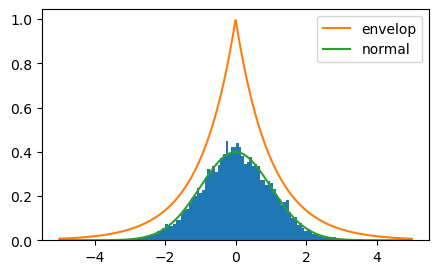

In [20]:
# C取得是近似值1.32
x = reject_sampling(f=N, g=lambda y: 1.32 * L(y), g_sampler=laplace, n=10000, max_iter=10000)  
fig1 = plt.figure(figsize=(5, 3))
plt.hist(x, 100, density=True)
y = np.linspace(-5, 5, 1000)
z = 2 * L(y)
plt.plot(y, z, label="envelop")
z = N(y)
plt.plot(y, z, label="normal")
plt.legend()
plt.show()

### (3) Can one simulate Laplace random variables using rejection sampling with a multiple of the standard normal density as the envelop? Why or why not?

这是不可以的，理由如下：
对$\forall C$，除式：
$$
Ratio=\frac{f(x)}{Cg(x)}=Cexp\{-\frac{1}{2}x^2+x\}
$$
总是存在充分大的$x\in R \:s.t.\: Ratio < 1$，故而不满足envelop的条件

## Problem 2

### (1) Let K be a positive integer. Show that the following estimate of π(x) is unbiased

求期望：
$$
E(\frac{1}{K}\sum_{i = 1}^K \frac{\pi(x,z_i)}{q(z_i)}) 
= \frac{1}{K}\sum_{i = 1}^K \int\frac{\pi(x,z_i)}{q(z_i)}q(z_i)dz_i
= \frac{1}{K}\sum_{i = 1}^K \int\pi(x,z_i)dz_i
= \pi(x)
$$
即该估计为无偏估计

### (2) Show that $\pi$ is a stationary distribution of the Markov chain


$$\hat{\pi}(x)p(x'|x) 
= \hat{\pi}(x) Q(x'|x)min\{1,\frac{\hat{\pi}(x')Q(x|x')}{\hat{\pi}(x)Q(x'|x)}\} 
= min\{\hat{\pi}(x) Q(x'|x),\hat{\pi}(x')Q(x|x')\}
= \hat{\pi}(x') Q(x|x')min\{1,\frac{\hat{\pi}(x)Q(x'|x)}{\hat{\pi}(x')Q(x|x')}\} 
= \hat{\pi}(x')p(x|x') 
$$
满足细致平稳条件

## Problem 3

### (1) Implement a Gibbs sampler for approximating the posterior of $(\beta, \sigma^2)$. Initialize the sampler at (25, 25) and run it for 20, 000 iterations (with no burn-in). Plot the samples on top of the contours of the true posterior.

参考Albert and Chib, 1995和Andrew,Bayesian Data Analysis,3rd edition，2013有：
$$
\pi(\beta, Z, \sigma^2 | y) = C\pi(\beta)\pi(\sigma^2)\prod_{i=1}^{N}\{1(Z_i>0)1(y_i=1) + 1(Z_i\le0)1(y_i=1)\}\phi(Z_i;x_i\beta, \sigma^2)
$$
取题目中的两个先验分布，得到各参数的边缘后验分布为：
$$Z_i | \beta, y, \sigma^2 ∼ \mathcal{N}(x_i\beta, \sigma^2) \: (truncated\:\mathcal{N})$$
$$\sigma^2 | \beta, y, Z ∼ Inv\text{-}\chi^2(3+N, \frac{3+\sum_{i=1}^{N}(Z_i-x_i\beta)^2}{3+N})$$
$$\beta |y, Z ∼ \mathcal{N}((100^{-1}+X^TX)^{-1}X^TZ, ((100^{-1}+X^TX)^{-1})$$

具体实现如下：

In [81]:
data = np.load("probit_data.npy")
x = data[:, 0]
y = data[:, 1]

In [82]:
x.shape[0]

100

In [83]:
def inv_chisq(df, scale):
    """
    产生服从逆转卡方分布的样本
    :param df: 自由度
    :param scale: 形状参数
    :return: 样本
    """
    return invgamma.rvs(a=df / 2, scale=df * scale / 2)


def posterior(beta, sigma):
    """
    后验分布（积掉Z）
    :param beta:
    :param sigma:
    :return:
    """
    return norm.pdf(beta, 0, 10) * invgamma.pdf(x=sigma ** 2, a=1.5, scale=1.5)


def gibbs(x, y, beta, sigma, MH_step=False, epochs=1000):
    """
    Gibbs sampler
    :param x:
    :param y:
    :param beta:
    :param sigma:
    :param MH_step: 是否启用MH
    :param epochs:
    :return:
    """
    N = x.shape[0]
    # t = x @ x  # 临时变量, X^TX
    Z = np.zeros(N)
    betas = []
    sigmas = []
    for epoch in range(epochs):
        # 保存上一次的结果
        beta0 = beta
        sigma0 = sigma
        # 抽取隐变量Z
        # 这个过程占用了本算法90%的CPU时间
        for i in range(100):
            if y[i] == 1:
                trunc_left = truncnorm(0, np.inf, x[i] * beta, sigma)
                Z[i] = trunc_left.rvs()
            else:
                trunc_right = truncnorm(-np.inf, 0, x[i] * beta, sigma)
                Z[i] = trunc_right.rvs()
        # 抽取sigma^2
        sigma2 = inv_chisq(3 + N, (3 + np.sum((Z - x * beta) ** 2, axis=0)) / (N + 3))
        sigma = np.sqrt(sigma2)
        # 抽取beta
        # beta = normal(x @ Z / (0.01 + t), 1 / ((0.01 + t)))
        beta = normal((np.sum(Z, axis=0) / sigma2 ) / (0.01 + N/sigma2), 1 / (0.01 + N/sigma2))

        # Metropolis-Hasting step
        if MH_step:
            s = exponential(1)
            beta = s * beta
            sigma = s * sigma
            ratio = min(posterior(beta, sigma) / posterior(beta0, sigma0), 1)
            u = uniform()
            if u <= ratio:
                betas.append(beta)
                sigmas.append(sigma)
            else:
                beta = beta0
                sigma = sigma0
            continue
        betas.append(beta)
        sigmas.append(sigma)
    return [betas, sigmas]

In [84]:
sample1 = gibbs(x, y, 25.0, 25.0, MH_step=False, epochs=5000)

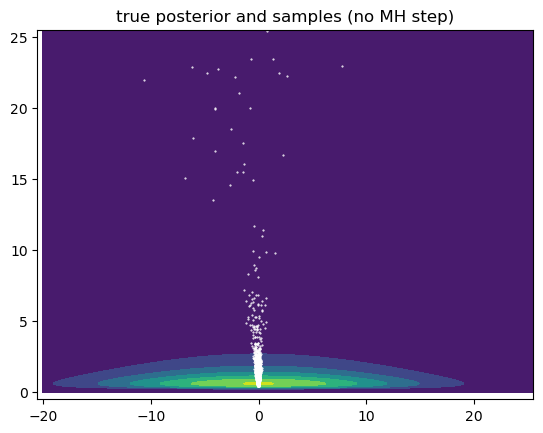

In [88]:
x, y = np.mgrid[-20:30:.05, 0:25:.05]
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.contourf(x, y**2, posterior(x, y))
ax1.scatter(sample1[0], sample1[1], marker='.', c='white', s=1)
plt.xlim(-20.5, 25.5)
plt.ylim(-0.5, 25.5)
plt.title("true posterior and samples (no MH step)")
plt.show()

### (2) Implement this sampler and conduct a similar simulation as in part (1), again plotting the samples on top of the contours of the true posterior. Which sampler mixes more quickly?

In [85]:
sample2 = gibbs(x, y, 25.0, 25.0, MH_step=True, epochs=5000)

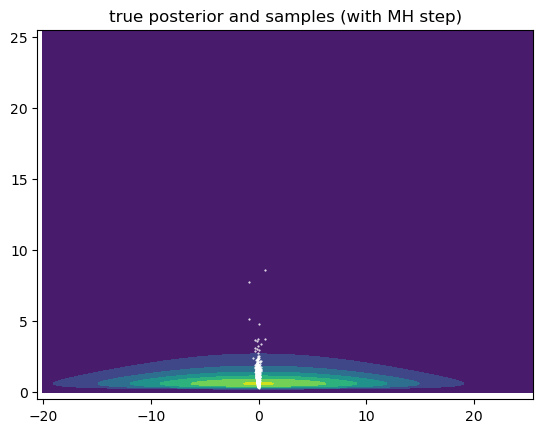

In [89]:
x, y = np.mgrid[-20:30:.05, 0:25:.05]
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.contourf(x, y**2, posterior(x, y))
ax1.scatter(sample2[0], sample2[1], marker='.', c='white', s=1)
plt.xlim(-20.5, 25.5)
plt.ylim(-0.5, 25.5)
plt.title("true posterior and samples (with MH step)")
plt.show()

> **从图中看应该是后一个收敛的更快**

## Problem 4

### (1) Implement a Hamiltonian Monte Carlo sampler to collect 500 samples (with 500 discarded as burn-in), show the scatter plot. Test the following two strategies for the number of leapfrog steps L: (1) use a fixed L; (2) use a random one, say Uniform(1, Lmax).Do you find any difference? Explain it.

In [273]:
def U(x, y, beta):
    """
    势函数
    :param x: 位置
    :param args: 密度函数的参数
    :return: 势能
    """
#     return -(y @ x @ beta - np.sum(np.log(1 + np.exp(x @ beta)), axis=0) +
#              (-0.5 * beta @ beta))
    return -(y @ x @ beta + np.sum(np.log(expit(-x @ beta.reshape((-1, 1)))), axis=0) +
             (-0.5 * beta @ beta))
#     p = expit(x @ beta.reshape((-1, 1)))
#     return -(y@np.log(p) + (1-y)@np.log(1-p) + (-0.5 * beta @ beta))


def dU(beta, *args):
    """
    势函数的微分
    :param x: 位置
    :param args: 密度函数的参数
    :return: 微分
    """
#     t = np.exp(x@beta)
#     return -(y@x - np.sum(np.atleast_2d(t / (1+t)).T * x, axis=0)) + beta
    t = expit(x @ beta.reshape((-1, 1))) # 可能更稳健
    return beta - (np.sum(x*y.reshape((-1, 1)), axis=0) - np.sum(t.reshape((-1, 1)) * x, axis=0))


def HMC(X, Y, initial, Lmax, step_size, fixed= True, epochs=1000):
    """
    Hamiltonian Monte Carlo
    :param initial: 初始点
    :param Lmax: 每轮次步数
    :param step_size: 步长
    :param epochs: 轮次
    :return: 样本
    """
    samples = [initial]
    for epoch in range(epochs):
        r = normal(0, 1, 2)  # 每轮epoch重新生成动量
        x = samples[-1]  # 上一次到达的位置
        # 先保存这次起点的位置
        x_prev = np.copy(x)
        r_prev = np.copy(r)
        # Simulate Hamiltonian dynamics
        if fixed:
            L = Lmax
        else:
            L = randint(1, Lmax+1)
        for step in range(L):
            # Leap-frog积分
            r = r - 0.5 * step_size * dU(x)  # 加上势函数的负梯度
            x = x + step_size * r  # 这里取的质量都是1
            r = r - 0.5 * step_size * dU(x)
        # flip the sign of the momentum
        r = -r
        # 计算接受概率
        ratio = np.exp(-(U(X, Y, x) + 0.5 * r @ r) + (U(X, Y, x_prev) + 0.5 * r_prev @ r_prev))
        accept = 1 if 1 < ratio else ratio
        u = uniform(0, 1)
        if u <= accept:
            samples.append(x)
        else:
            samples.append(x_prev)
    return samples

In [3]:
data = np.load('mcs_hw2_p3_data.npy')[1000:]
x = data[:, :2]
y = data[:, 2]

### Leap-frog固定步数与随机步数

In [276]:
initial = np.array([1.0, 1.0])
trial1 = HMC(x, y, initial, Lmax = 10, step_size=0.001, fixed=True,epochs=1000)
trial1 = np.array(trial1)
trial2 = HMC(x, y, initial, Lmax = 20, step_size=0.001, fixed=False,epochs=1000)
trial2 = np.array(trial2)

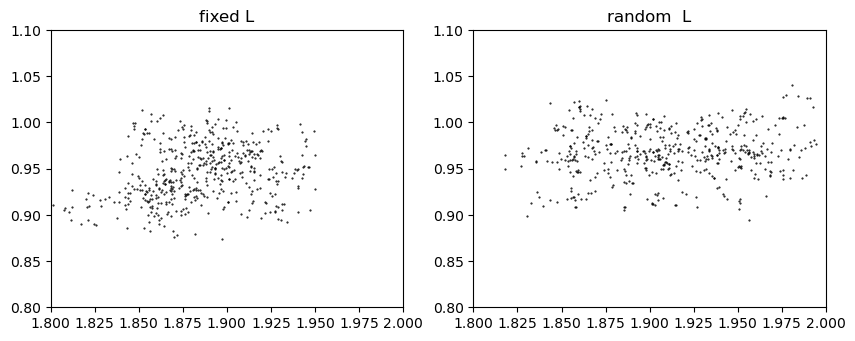

In [280]:
fig1 = plt.figure(figsize=(10, 3.6))
ax1 = fig1.add_subplot(121)
# 只取后500个样本
ax1.scatter(trial1[500:, 0], trial1[500:, 1], marker='.', c = "black", s=1)
plt.xlim(1.8, 2)
plt.ylim(0.8, 1.1)
plt.title("fixed L")
ax2 = fig1.add_subplot(122)
ax2.scatter(trial2[500:, 0], trial2[500:, 1], marker='.', c = "black", s=1)
plt.title("random  L")
plt.xlim(1.8, 2)
plt.ylim(0.8, 1.1)
plt.show()

> **随机步数的情况下（假设期望同L），有一半的概率HMC模拟步数比L大，于是从图中看出样本点的范围更大，有利于采集到小概率（密度）的样本，同时还有一半的概率步数比L小，或许有利于避免U-turn的发生**

### (2) Run HMC for 100000 iterations and discard the first 50000 samples as burn-in to form the ground truth. Implement stochastic gradient MCMC algorithms including SGLD, SGHMC and SGNHT

In [281]:
# Ground Truth
initial = np.array([1.0, 1.0])
trial3 = HMC(x, y, initial, Lmax = 10, step_size=0.001, fixed=True,epochs=100000)

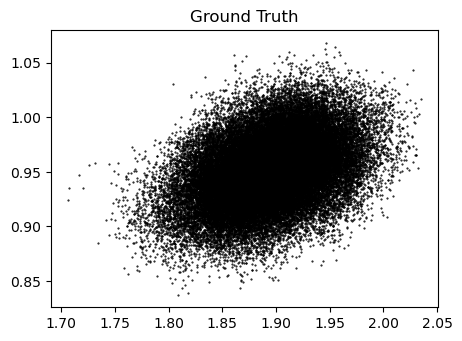

In [283]:
trial3 = np.array(trial3)
fig1 = plt.figure(figsize=(5, 3.6))
ax1 = fig1.add_subplot(111)
# 只取后50000个样本
ax1.scatter(trial3[50000:, 0], trial3[50000:, 1], marker='.', c = "black", s=1)
plt.title("Ground Truth")
plt.show()

In [291]:
np.save("ground_truth", trial3)

### 1. SGLD:

In [5]:
def grad_posterior(beta, x, y, ratio):
    """
    后验密度的梯度
    :param beta: 参数
    :param x: 样本（MiniBatch）
    :param y: 样本（MiniBatch）
    :param ratio: FullBatch/miniBatch
    :return: 梯度
    """
    # t = 1 / (1 + np.exp(-x @ beta.reshape((-1, 1))))
    t = expit(x @ beta.reshape((-1, 1))) # 可能更稳健
    return - beta + ratio * (np.sum(x*y.reshape((-1, 1)), axis=0) - np.sum(t.reshape((-1, 1)) * x, axis=0))


def sample(x, y, batch_size):
    index = np.arange(x.shape[0])
    shuffle(index)
    sample_index = index[: batch_size]
    return x[sample_index], y[sample_index]


def sgld(beta, x, y, batch_size=100, epochs=1000):
    """
    SGLD算法
    :param beta: 初始参数
    :param x: 输入x
    :param y: 输入y
    :param batch_size: 随机梯度的样本大小 
    :param epochs: 迭代次数
    :return: 样本
    """
    traces = [beta]
    for epoch in range(epochs):
        epsilon = 1 / (epoch + 1) ** 0.6  # 保证收敛性
        eta = normal(0, epsilon)  # 布朗运动项
        x_batch, y_batch = sample(x, y, batch_size)
        beta = beta + 0.5*epsilon*grad_posterior(beta, x_batch, y_batch, ratio=x.shape[0] / batch_size) + eta
        traces.append(beta)
    return traces

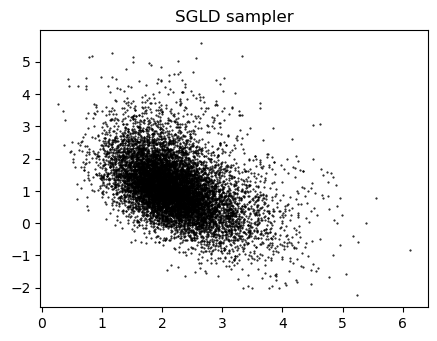

In [213]:
initial = np.array([1.0, 1.0])
trial4 = sgld(initial, x, y, epochs=20000)
trial4 = np.array(trial4)
fig1 = plt.figure(figsize=(5, 3.6))
ax1 = fig1.add_subplot(111)
# 只取后500个样本
ax1.scatter(trial4[10000:, 0], trial4[10000:, 1], marker='.', c = "black", s=1)
plt.title("SGLD sampler")
plt.show()

### 2. SGHMC:

In [6]:
def sghmc(beta, x, y, L = 10, batch_size=100, epochs=1000):
    """
    Stochastic Gradient HMC算法
    :param beta: 初始参数
    :param x: 输入x
    :param y: 输入y
    :param L: HMC模拟的步数
    :param batch_size: 随机梯度的样本大小
    :param epochs: 迭代次数
    :return: 样本
    """
    traces = [beta]
    for epoch in range(epochs):
        epsilon = 1 / (epoch + 1) ** 0.6  # 保证收敛性
        r = normal(0, 1, 2)  # 速度
        for l in range(L):
            eta = normal(0, 2*epsilon)  # 布朗运动项
            x_batch, y_batch = sample(x, y, batch_size)
            beta = beta + epsilon*r
            r = r + epsilon*grad_posterior(beta, x_batch, y_batch, ratio=x.shape[0] / batch_size) \
                - epsilon*r + eta
        traces.append(beta)
    return traces

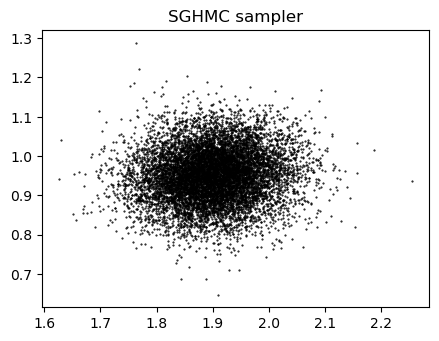

In [210]:
initial = np.array([1.0, 1.0])
trial5 = sghmc(initial, x, y, epochs=20000)
trial5 = np.array(trial5)
fig1 = plt.figure(figsize=(5, 3.6))
ax1 = fig1.add_subplot(111)
# 只取后500个样本
ax1.scatter(trial5[10000:, 0], trial5[10000:, 1], marker='.', c = "black", s=1)
plt.title("SGHMC sampler")
plt.show()

### 3. SGNHT:

In [11]:
def sgnht(x, y, A = 0.01, batch_size=100, epochs=1000):
    """
    Stochastic Gradient Nos´e-Hoover Thermostat
    :param x: 输入x
    :param y: 输入y
    :param A: ksi的初始值
    :param batch_size: 随机梯度的样本大小
    :param epochs: 迭代次数
    :return: 样本
    """
    beta = normal(0, 1, 2)
    r = normal(0, 1, 2)
    ksi = A
    traces = [beta]
    for epoch in range(epochs):
        epsilon = 1 / (epoch + 1) ** 0.6  # 保证收敛性
        eta = (2 * A)**0.5*normal(0, 0.01, 2)  # 布朗运动项
        # 更新过程
        x_batch, y_batch = sample(x, y, batch_size)
        r = r + epsilon * grad_posterior(beta, x_batch, y_batch, ratio=x.shape[0] / batch_size) - epsilon * ksi * r + eta
        print(r)
        beta = beta + epsilon * r
        ksi = ksi + epsilon*(r@r/2 - 1)
        traces.append(beta)
    return traces

[-613.86169899  405.35730815]
[ 1.09583459e+08 -7.23604360e+07]
[-3.22460529e+23  2.12927978e+23]
[ 5.42067325e+69 -3.57939311e+69]
[-1.89528264e+208  1.25149798e+208]
[ inf -inf]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]


C:\Users\Actio\AppData\Local\Temp\ipykernel_29528\1356762702.py:24: RuntimeWarning: overflow encountered in matmul
  ksi = ksi + epsilon*(r@r/2 - 1)
C:\Users\Actio\AppData\Local\Temp\ipykernel_29528\162765238.py:11: RuntimeWarning: invalid value encountered in matmul
  t = expit(x @ beta.reshape((-1, 1))) # 可能更稳健


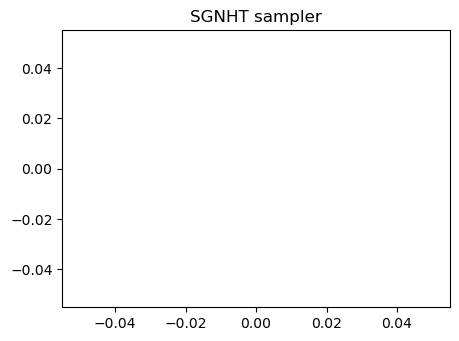

In [12]:
initial = np.array([1.0, 1.0])
trial6 = np.array(sgnht(x, y, epochs=20))
fig1 = plt.figure(figsize=(5, 3.6))
ax1 = fig1.add_subplot(111)
ax1.scatter(trial6[10000:, 0], trial6[10000:, 1], marker='.', c = "black", s=1)
plt.title("SGNHT sampler")
plt.show()

In [292]:
np.save("sgld", trial4)
np.save("sghmc", trial5)
np.save("sgnht", trial6)

### 4. 三种方法的收敛速度比较（KL divergence）

In [214]:
import ite

In [215]:
co = ite.cost.BDKL_KnnK()

In [227]:
co.estimation(normal(0, 1, (2000, 3)), normal(0, 1, (3000, 3)))   # 测试

0.00863563722735644

In [286]:
KL_sgld = []
KL_sghmc = []
KL_sgnht = []
for i in range(1, 401):
    index = i*50
    KL_sgld.append(co.estimation(trial4[0:index], trial3[50000:]))
    KL_sghmc.append(co.estimation(trial5[0:index], trial3[50000:]))
    KL_sgnht.append(co.estimation(trial6[0:index], trial3[50000:]))

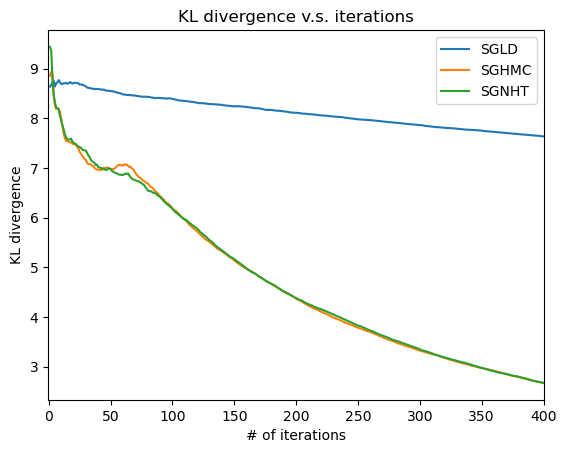

In [290]:
plt.plot(np.arange(1, 400+1, 1), KL_sgld, label="SGLD")
plt.plot(np.arange(1, 400+1, 1), KL_sghmc, label="SGHMC")
plt.plot(np.arange(1, 400+1, 1), KL_sgnht, label="SGNHT")
plt.xlim(-0.5, 400+0.5)
plt.title("KL divergence v.s. iterations")
plt.xlabel("# of iterations")
plt.ylabel("KL divergence")
plt.legend()
plt.show()

> **从图中知道SGNHT和SGHMC最快收敛到目标分布，SGLD没有收敛到目标分布**